In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.1907 - STD: 1.2386e-04 - MAE: 0.4234

 4/64 [>.............................] - ETA: 1s - loss: 0.0682 - STD: 4.0755e-04 - MAE: 0.1994  

 5/64 [=>............................] - ETA: 2s - loss: 0.0608 - STD: 3.6609e-04 - MAE: 0.1870

 6/64 [=>............................] - ETA: 2s - loss: 0.0570 - STD: 3.2524e-04 - MAE: 0.1823

 7/64 [==>...........................] - ETA: 2s - loss: 0.0547 - STD: 2.9028e-04 - MAE: 0.1801

 8/64 [==>...........................] - ETA: 2s - loss: 0.0530 - STD: 2.6166e-04 - MAE: 0.1788

 9/64 [===>..........................] - ETA: 2s - loss: 0.0517 - STD: 2.3899e-04 - MAE: 0.1777

10/64 [===>..........................] - ETA: 2s - loss: 0.0505 - STD: 2.2153e-04 - MAE: 0.1763

11/64 [====>.........................] - ETA: 2s - loss: 0.0493 - STD: 2.0842e-04 - MAE: 0.1746

12/64 [====>.........................] - ETA: 2s - loss: 0.0481 - STD: 1.9860e-04 - MAE: 0.1723

13/64 [=====>........................] - ETA: 2s - loss: 0.0467 - STD: 1.9156e-04 - MAE: 0.1693

14/64 [=====>........................] - ETA: 2s - loss: 0.0452 - STD: 1.8644e-04 - MAE: 0.1655

15/64 [======>.......................] - ETA: 2s - loss: 0.0437 - STD: 1.8283e-04 - MAE: 0.1609

16/64 [======>.......................] - ETA: 2s - loss: 0.0420 - STD: 1.8003e-04 - MAE: 0.1555

17/64 [======>.......................] - ETA: 2s - loss: 0.0404 - STD: 1.7782e-04 - MAE: 0.1500

18/64 [=======>......................] - ETA: 2s - loss: 0.0389 - STD: 1.7591e-04 - MAE: 0.1453

19/64 [=======>......................] - ETA: 2s - loss: 0.0375 - STD: 1.7395e-04 - MAE: 0.1418

20/64 [========>.....................] - ETA: 2s - loss: 0.0364 - STD: 1.7195e-04 - MAE: 0.1396

21/64 [========>.....................] - ETA: 2s - loss: 0.0354 - STD: 1.6976e-04 - MAE: 0.1382

22/64 [=========>....................] - ETA: 2s - loss: 0.0346 - STD: 1.6748e-04 - MAE: 0.1374

23/64 [=========>....................] - ETA: 2s - loss: 0.0339 - STD: 1.6502e-04 - MAE: 0.1368

24/64 [==========>...................] - ETA: 2s - loss: 0.0333 - STD: 1.6256e-04 - MAE: 0.1361

25/64 [==========>...................] - ETA: 2s - loss: 0.0326 - STD: 1.6014e-04 - MAE: 0.1351

26/64 [===========>..................] - ETA: 2s - loss: 0.0319 - STD: 1.5772e-04 - MAE: 0.1337

27/64 [===========>..................] - ETA: 2s - loss: 0.0313 - STD: 1.5540e-04 - MAE: 0.1321

28/64 [============>.................] - ETA: 2s - loss: 0.0306 - STD: 1.5308e-04 - MAE: 0.1302

29/64 [============>.................] - ETA: 2s - loss: 0.0300 - STD: 1.5086e-04 - MAE: 0.1281

30/64 [=============>................] - ETA: 2s - loss: 0.0294 - STD: 1.4870e-04 - MAE: 0.1260

31/64 [=============>................] - ETA: 2s - loss: 0.0289 - STD: 1.4660e-04 - MAE: 0.1239

32/64 [==============>...............] - ETA: 2s - loss: 0.0285 - STD: 1.4461e-04 - MAE: 0.1219

33/64 [==============>...............] - ETA: 1s - loss: 0.0281 - STD: 1.4272e-04 - MAE: 0.1201

34/64 [==============>...............] - ETA: 1s - loss: 0.0276 - STD: 1.4094e-04 - MAE: 0.1183

35/64 [===============>..............] - ETA: 1s - loss: 0.0273 - STD: 1.3933e-04 - MAE: 0.1167

36/64 [===============>..............] - ETA: 1s - loss: 0.0269 - STD: 1.3786e-04 - MAE: 0.1151

37/64 [================>.............] - ETA: 2s - loss: 0.0269 - STD: 1.3649e-04 - MAE: 0.1136

40/64 [=================>............] - ETA: 1s - loss: 0.0258 - STD: 1.3353e-04 - MAE: 0.1098

42/64 [==================>...........] - ETA: 1s - loss: 0.0251 - STD: 1.3227e-04 - MAE: 0.1078

43/64 [===================>..........] - ETA: 1s - loss: 0.0248 - STD: 1.3182e-04 - MAE: 0.1071

44/64 [===================>..........] - ETA: 1s - loss: 0.0245 - STD: 1.3148e-04 - MAE: 0.1064

45/64 [====================>.........] - ETA: 1s - loss: 0.0243 - STD: 1.3125e-04 - MAE: 0.1059

46/64 [====================>.........] - ETA: 1s - loss: 0.0240 - STD: 1.3108e-04 - MAE: 0.1054

47/64 [=====================>........] - ETA: 1s - loss: 0.0238 - STD: 1.3098e-04 - MAE: 0.1049

48/64 [=====================>........] - ETA: 1s - loss: 0.0236 - STD: 1.3096e-04 - MAE: 0.1044

49/64 [=====================>........] - ETA: 1s - loss: 0.0234 - STD: 1.3100e-04 - MAE: 0.1039

50/64 [======================>.......] - ETA: 1s - loss: 0.0231 - STD: 1.3109e-04 - MAE: 0.1033

51/64 [======================>.......] - ETA: 0s - loss: 0.0229 - STD: 1.3120e-04 - MAE: 0.1028

52/64 [=======================>......] - ETA: 0s - loss: 0.0227 - STD: 1.3139e-04 - MAE: 0.1021

53/64 [=======================>......] - ETA: 0s - loss: 0.0225 - STD: 1.3160e-04 - MAE: 0.1015

54/64 [========================>.....] - ETA: 0s - loss: 0.0224 - STD: 1.3186e-04 - MAE: 0.1008

55/64 [========================>.....] - ETA: 0s - loss: 0.0222 - STD: 1.3213e-04 - MAE: 0.1001

56/64 [=========================>....] - ETA: 0s - loss: 0.0220 - STD: 1.3250e-04 - MAE: 0.0995

57/64 [=========================>....] - ETA: 0s - loss: 0.0218 - STD: 1.3293e-04 - MAE: 0.0989

58/64 [==========================>...] - ETA: 0s - loss: 0.0217 - STD: 1.3342e-04 - MAE: 0.0983

59/64 [==========================>...] - ETA: 0s - loss: 0.0215 - STD: 1.3398e-04 - MAE: 0.0977

60/64 [===========================>..] - ETA: 0s - loss: 0.0214 - STD: 1.3467e-04 - MAE: 0.0972

61/64 [===========================>..] - ETA: 0s - loss: 0.0212 - STD: 1.3540e-04 - MAE: 0.0967

62/64 [============================>.] - ETA: 0s - loss: 0.0211 - STD: 1.3623e-04 - MAE: 0.0962

63/64 [============================>.] - ETA: 0s - loss: 0.0209 - STD: 1.3715e-04 - MAE: 0.0958

64/64 [==============================] - ETA: 0s - loss: 0.0208 - STD: 1.3812e-04 - MAE: 0.0954

64/64 [==============================] - 7s 82ms/step - loss: 0.0208 - STD: 1.3812e-04 - MAE: 0.0954 - val_loss: 0.0167 - val_STD: 1.5417e-04 - val_MAE: 0.0816


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0133 - STD: 2.0893e-04 - MAE: 0.0740

 2/64 [..............................] - ETA: 4s - loss: 0.0127 - STD: 2.1290e-04 - MAE: 0.0730

 3/64 [>.............................] - ETA: 4s - loss: 0.0127 - STD: 2.1700e-04 - MAE: 0.0733

 4/64 [>.............................] - ETA: 4s - loss: 0.0127 - STD: 2.2034e-04 - MAE: 0.0734

 5/64 [=>............................] - ETA: 4s - loss: 0.0126 - STD: 2.2457e-04 - MAE: 0.0734

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 2.2865e-04 - MAE: 0.0735

 7/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 2.3233e-04 - MAE: 0.0733

 8/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 2.3646e-04 - MAE: 0.0732

 9/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 2.4045e-04 - MAE: 0.0729

10/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 2.4448e-04 - MAE: 0.0726

11/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 2.4881e-04 - MAE: 0.0723

12/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 2.5300e-04 - MAE: 0.0719

13/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 2.5742e-04 - MAE: 0.0716

14/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 2.6205e-04 - MAE: 0.0713

15/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 2.6694e-04 - MAE: 0.0710

16/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 2.7237e-04 - MAE: 0.0709

17/64 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 2.7793e-04 - MAE: 0.0707

18/64 [=======>......................] - ETA: 3s - loss: 0.0127 - STD: 2.8392e-04 - MAE: 0.0707

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 2.9021e-04 - MAE: 0.0706

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 2.9665e-04 - MAE: 0.0706

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 3.0354e-04 - MAE: 0.0706

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 3.1077e-04 - MAE: 0.0707

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 3.1804e-04 - MAE: 0.0707

24/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 3.2571e-04 - MAE: 0.0706

25/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 3.3382e-04 - MAE: 0.0707

26/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 3.4212e-04 - MAE: 0.0707

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 3.5090e-04 - MAE: 0.0707

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 3.6002e-04 - MAE: 0.0707

29/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 3.6969e-04 - MAE: 0.0707

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 3.7960e-04 - MAE: 0.0707

31/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 3.9009e-04 - MAE: 0.0706

32/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 4.0102e-04 - MAE: 0.0705

33/64 [==============>...............] - ETA: 2s - loss: 0.0127 - STD: 4.1264e-04 - MAE: 0.0705

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 4.2472e-04 - MAE: 0.0705

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 4.3744e-04 - MAE: 0.0705

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 4.5083e-04 - MAE: 0.0705

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 4.6520e-04 - MAE: 0.0705

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 4.7997e-04 - MAE: 0.0705

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 4.9565e-04 - MAE: 0.0704

40/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 5.1216e-04 - MAE: 0.0704

41/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 5.2985e-04 - MAE: 0.0704

42/64 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 5.4802e-04 - MAE: 0.0704

43/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 5.6759e-04 - MAE: 0.0704

44/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 5.8821e-04 - MAE: 0.0704

45/64 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 6.1015e-04 - MAE: 0.0703

46/64 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 6.3302e-04 - MAE: 0.0703

47/64 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 6.5753e-04 - MAE: 0.0702

48/64 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 6.8341e-04 - MAE: 0.0702

49/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 7.1108e-04 - MAE: 0.0702

50/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 7.4044e-04 - MAE: 0.0701

51/64 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 7.7154e-04 - MAE: 0.0701

52/64 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 8.0544e-04 - MAE: 0.0700

53/64 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 8.4134e-04 - MAE: 0.0700

54/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 8.7966e-04 - MAE: 0.0700

55/64 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 9.2068e-04 - MAE: 0.0700

56/64 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 9.6433e-04 - MAE: 0.0699

57/64 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0699    

58/64 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0699

60/64 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0699

61/64 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0699

62/64 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0698

63/64 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0698

64/64 [==============================] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0698

64/64 [==============================] - 4s 69ms/step - loss: 0.0125 - STD: 0.0014 - MAE: 0.0698 - val_loss: 0.0156 - val_STD: 0.0048 - val_MAE: 0.0761


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0115 - STD: 0.0066 - MAE: 0.0670

 2/64 [..............................] - ETA: 4s - loss: 0.0117 - STD: 0.0069 - MAE: 0.0671

 3/64 [>.............................] - ETA: 4s - loss: 0.0117 - STD: 0.0072 - MAE: 0.0670

 4/64 [>.............................] - ETA: 4s - loss: 0.0117 - STD: 0.0074 - MAE: 0.0667

 5/64 [=>............................] - ETA: 4s - loss: 0.0116 - STD: 0.0077 - MAE: 0.0663

 6/64 [=>............................] - ETA: 3s - loss: 0.0116 - STD: 0.0081 - MAE: 0.0662

 7/64 [==>...........................] - ETA: 3s - loss: 0.0115 - STD: 0.0084 - MAE: 0.0659

 8/64 [==>...........................] - ETA: 3s - loss: 0.0114 - STD: 0.0088 - MAE: 0.0657

 9/64 [===>..........................] - ETA: 3s - loss: 0.0114 - STD: 0.0092 - MAE: 0.0655

10/64 [===>..........................] - ETA: 3s - loss: 0.0113 - STD: 0.0096 - MAE: 0.0653

11/64 [====>.........................] - ETA: 3s - loss: 0.0112 - STD: 0.0100 - MAE: 0.0652

12/64 [====>.........................] - ETA: 3s - loss: 0.0112 - STD: 0.0104 - MAE: 0.0650

13/64 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.0109 - MAE: 0.0647

14/64 [=====>........................] - ETA: 3s - loss: 0.0110 - STD: 0.0114 - MAE: 0.0645

15/64 [======>.......................] - ETA: 3s - loss: 0.0109 - STD: 0.0119 - MAE: 0.0642

16/64 [======>.......................] - ETA: 3s - loss: 0.0108 - STD: 0.0124 - MAE: 0.0639

17/64 [======>.......................] - ETA: 3s - loss: 0.0107 - STD: 0.0130 - MAE: 0.0637

18/64 [=======>......................] - ETA: 3s - loss: 0.0107 - STD: 0.0135 - MAE: 0.0633

19/64 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 0.0141 - MAE: 0.0631

20/64 [========>.....................] - ETA: 2s - loss: 0.0105 - STD: 0.0147 - MAE: 0.0628

21/64 [========>.....................] - ETA: 2s - loss: 0.0104 - STD: 0.0154 - MAE: 0.0625

22/64 [=========>....................] - ETA: 2s - loss: 0.0104 - STD: 0.0160 - MAE: 0.0622

23/64 [=========>....................] - ETA: 2s - loss: 0.0103 - STD: 0.0168 - MAE: 0.0620

24/64 [==========>...................] - ETA: 2s - loss: 0.0102 - STD: 0.0175 - MAE: 0.0617

25/64 [==========>...................] - ETA: 2s - loss: 0.0101 - STD: 0.0183 - MAE: 0.0614

26/64 [===========>..................] - ETA: 2s - loss: 0.0100 - STD: 0.0191 - MAE: 0.0611

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 0.0199 - MAE: 0.0608

28/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0207 - MAE: 0.0605

30/64 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0223 - MAE: 0.0596

31/64 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 0.0231 - MAE: 0.0592

32/64 [==============>...............] - ETA: 2s - loss: 0.0095 - STD: 0.0240 - MAE: 0.0589

33/64 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0249 - MAE: 0.0585

34/64 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.0258 - MAE: 0.0581

35/64 [===============>..............] - ETA: 1s - loss: 0.0091 - STD: 0.0268 - MAE: 0.0578

36/64 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.0278 - MAE: 0.0574

37/64 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.0288 - MAE: 0.0570

38/64 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.0297 - MAE: 0.0567

39/64 [=================>............] - ETA: 1s - loss: 0.0087 - STD: 0.0306 - MAE: 0.0563

40/64 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.0316 - MAE: 0.0560

41/64 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0326 - MAE: 0.0556

42/64 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0336 - MAE: 0.0553

43/64 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0345 - MAE: 0.0550

44/64 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0355 - MAE: 0.0547

45/64 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0364 - MAE: 0.0544

46/64 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0373 - MAE: 0.0541

47/64 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0382 - MAE: 0.0537

48/64 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0534

49/64 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0400 - MAE: 0.0531

50/64 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.0409 - MAE: 0.0528

51/64 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0418 - MAE: 0.0525

52/64 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0426 - MAE: 0.0522

53/64 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0435 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0443 - MAE: 0.0517

55/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0450 - MAE: 0.0514

56/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0458 - MAE: 0.0512

57/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0466 - MAE: 0.0509

58/64 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0474 - MAE: 0.0507

59/64 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0481 - MAE: 0.0504

60/64 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0488 - MAE: 0.0502

61/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0495 - MAE: 0.0500

62/64 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0503 - MAE: 0.0498

63/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0509 - MAE: 0.0496

64/64 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0515 - MAE: 0.0493

64/64 [==============================] - 5s 70ms/step - loss: 0.0067 - STD: 0.0515 - MAE: 0.0493 - val_loss: 0.0045 - val_STD: 0.0705 - val_MAE: 0.0412


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0896 - MAE: 0.0357

 2/64 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0915 - MAE: 0.0359

 3/64 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0921 - MAE: 0.0359

 4/64 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0929 - MAE: 0.0358

 5/64 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0358

 6/64 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0357

 7/64 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0355

 8/64 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0936 - MAE: 0.0354

 9/64 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0353

10/64 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0352

11/64 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0351

12/64 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0351

13/64 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0351

14/64 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0350

15/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0350

16/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0349

17/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0349

18/64 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0348

19/64 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0348

20/64 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0949 - MAE: 0.0347

21/64 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0947 - MAE: 0.0346

22/64 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0948 - MAE: 0.0346

23/64 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0951 - MAE: 0.0345

24/64 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0345

25/64 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0344

26/64 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0953 - MAE: 0.0344

27/64 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0343

28/64 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0957 - MAE: 0.0343

29/64 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0343

30/64 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0342

31/64 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0342

32/64 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0959 - MAE: 0.0341

33/64 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0341

34/64 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0340

35/64 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0340

36/64 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0339

37/64 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0961 - MAE: 0.0339

38/64 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0338

39/64 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0338

40/64 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0963 - MAE: 0.0338

41/64 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0337

42/64 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0337

43/64 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0965 - MAE: 0.0336

44/64 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0965 - MAE: 0.0336

45/64 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0335

46/64 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0335

47/64 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0335

48/64 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0334

49/64 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0334

51/64 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0333

52/64 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0333

53/64 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0332

54/64 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0332

55/64 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0331

56/64 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0973 - MAE: 0.0331

57/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0331

58/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0330

59/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0330

60/64 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0329

61/64 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0329

62/64 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0976 - MAE: 0.0328

63/64 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0976 - MAE: 0.0328

64/64 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0976 - MAE: 0.0328

64/64 [==============================] - 4s 68ms/step - loss: 0.0025 - STD: 0.0976 - MAE: 0.0328 - val_loss: 0.0023 - val_STD: 0.0849 - val_MAE: 0.0326


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0305

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0305

 3/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0304

 4/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0303

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0303

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0303

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0302

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0302

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0302

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0302

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0302

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0302

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0301

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0301

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0300

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0300

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0300

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0300

19/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0299

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0299

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0299

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0298

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0298

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0298

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0298

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0298

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0297

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0297

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0297

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0297

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0297

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0296

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0297

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0296

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0296

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0296

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0296

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0296

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0296

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0296

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0296

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0296

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0295

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0295

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0295

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0295

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0295

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1016 - MAE: 0.0295

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0295

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0294

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0294

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0294

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0294

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0294

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0294

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0294

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0294

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0294

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0294

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293

64/64 [==============================] - 4s 68ms/step - loss: 0.0019 - STD: 0.1022 - MAE: 0.0293 - val_loss: 0.0021 - val_STD: 0.0929 - val_MAE: 0.0312


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0283

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0282

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0284

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0284

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0283

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0283

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0285

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0285

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0284

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0285

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0284

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0285

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0286

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0285

17/64 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0286

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0286

19/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0286

20/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0286

21/64 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0286

22/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0286

23/64 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0286

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0286

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0285

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0285

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0285

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0285

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0285

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0285

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0285

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0285

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0284

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0284

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0284

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0284

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0284

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0284

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0284

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0284

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0284

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0284

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0284

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0284

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

64/64 [==============================] - 4s 68ms/step - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.0925 - val_MAE: 0.0296


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0277

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0277

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0278

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0277

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0279

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0277

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277 - val_loss: 0.0018 - val_STD: 0.0928 - val_MAE: 0.0290


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.0998 - MAE: 0.0267

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0282

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0279

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0279

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0280

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0280

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0280

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0280

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0280

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

64/64 [==============================] - 4s 69ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277 - val_loss: 0.0016 - val_STD: 0.0917 - val_MAE: 0.0284


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0983 - MAE: 0.0283

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0292

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0286

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0273

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

64/64 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271 - val_loss: 0.0016 - val_STD: 0.0923 - val_MAE: 0.0282


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0280

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269 - val_loss: 0.0017 - val_STD: 0.0957 - val_MAE: 0.0286


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1089 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1087 - MAE: 0.0272

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0273

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1067 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0272

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0272

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0272

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0272

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0272

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0278

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0280

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0279

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0280

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

64/64 [==============================] - 4s 68ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274 - val_loss: 0.0018 - val_STD: 0.0971 - val_MAE: 0.0291


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0264

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1079 - MAE: 0.0265

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0265

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0964 - val_MAE: 0.0295


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1076 - MAE: 0.0276

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0269

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0979 - val_MAE: 0.0294


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0948 - val_MAE: 0.0281


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0261

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0978 - val_MAE: 0.0302


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1099 - MAE: 0.0266

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0969 - val_MAE: 0.0287


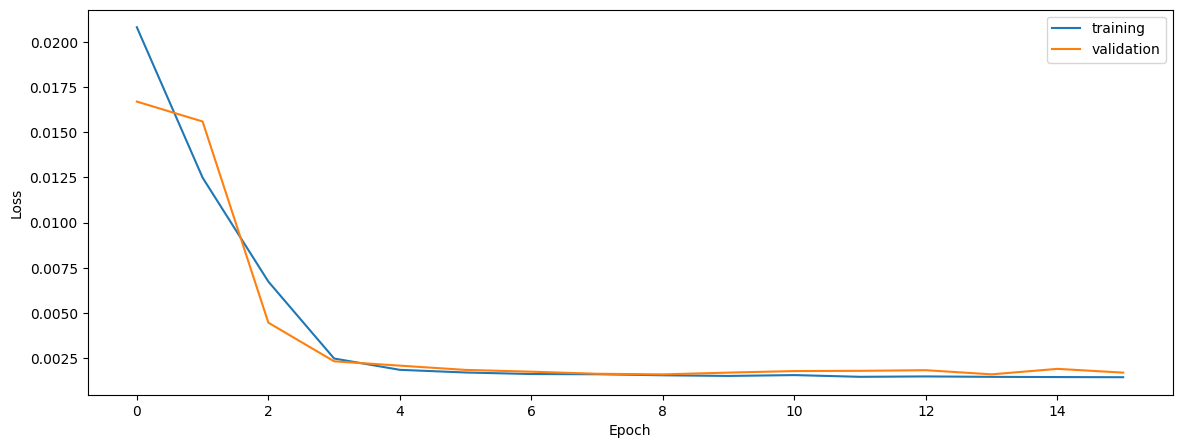

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9383663723861229
0.9508104043596681
0.9489200681570688


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.9383663723861229
0.9508104043596681
0.9489200681570688


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.9459646812419377
0.9538631035736536
0.9619433214851149


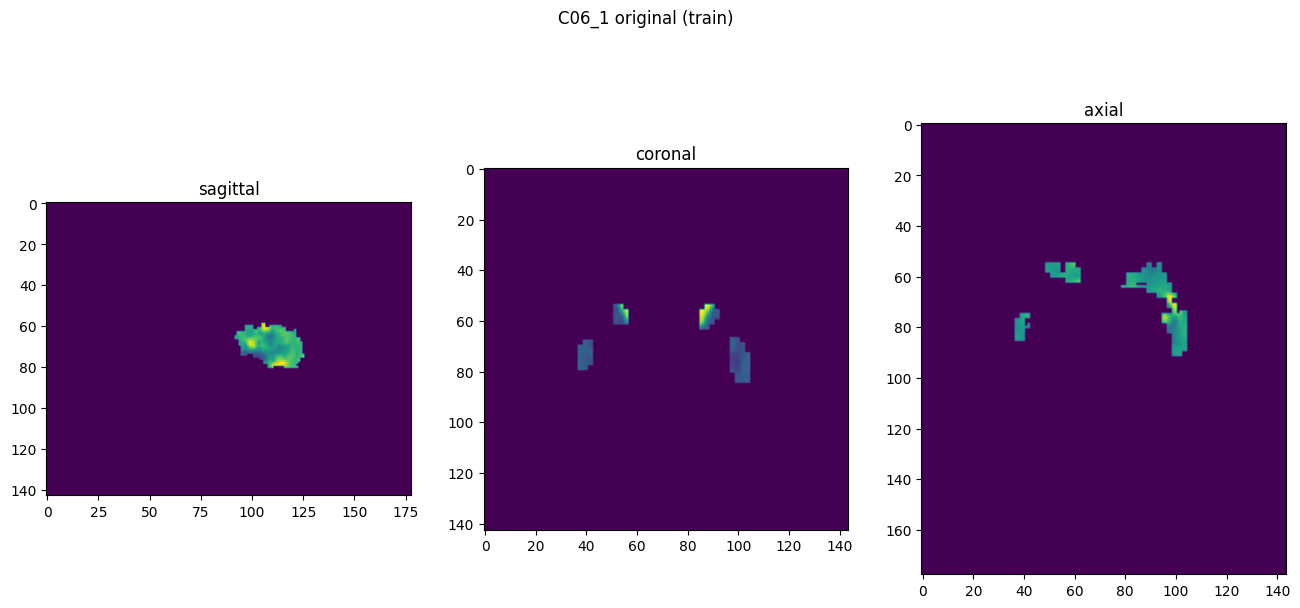

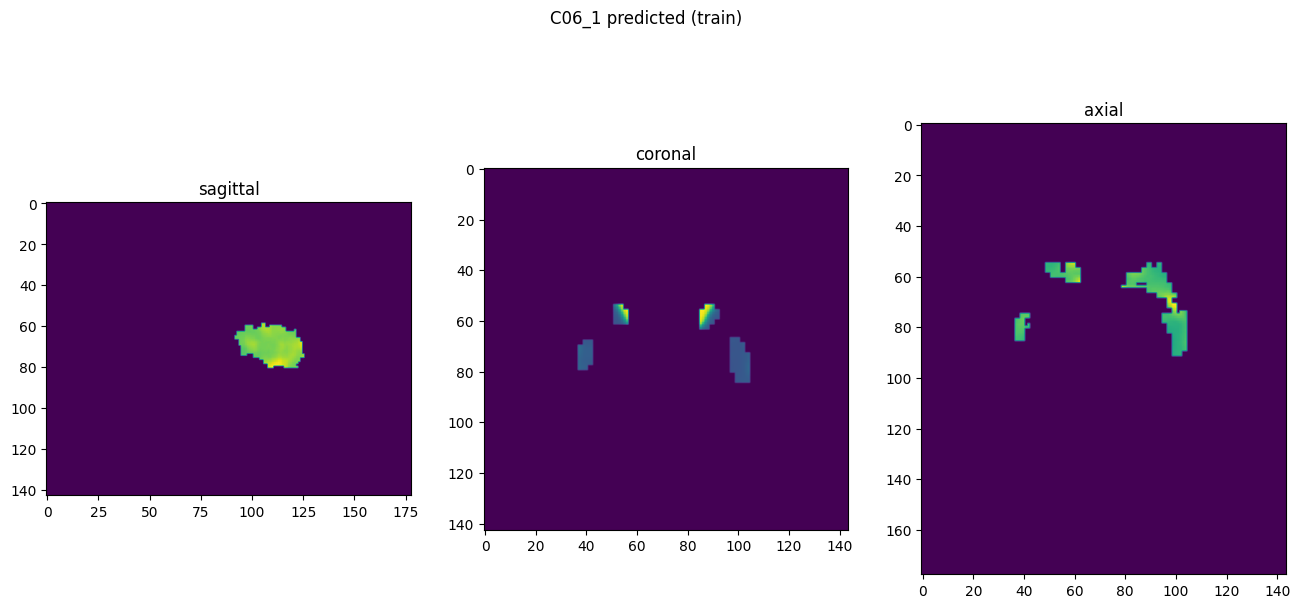

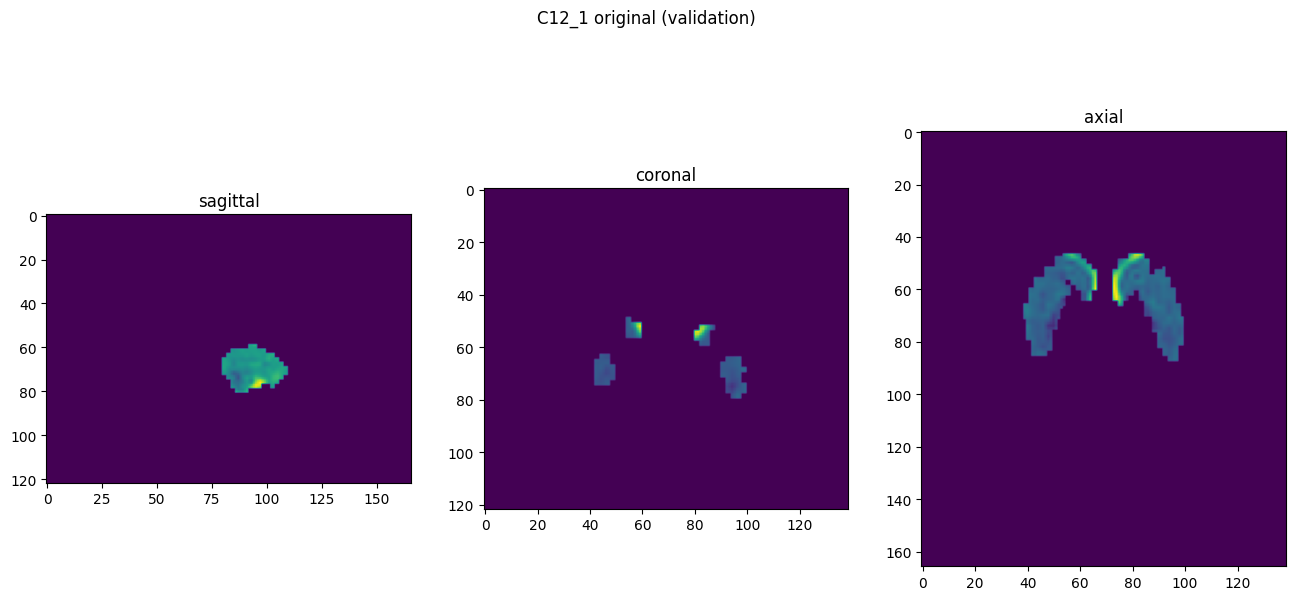

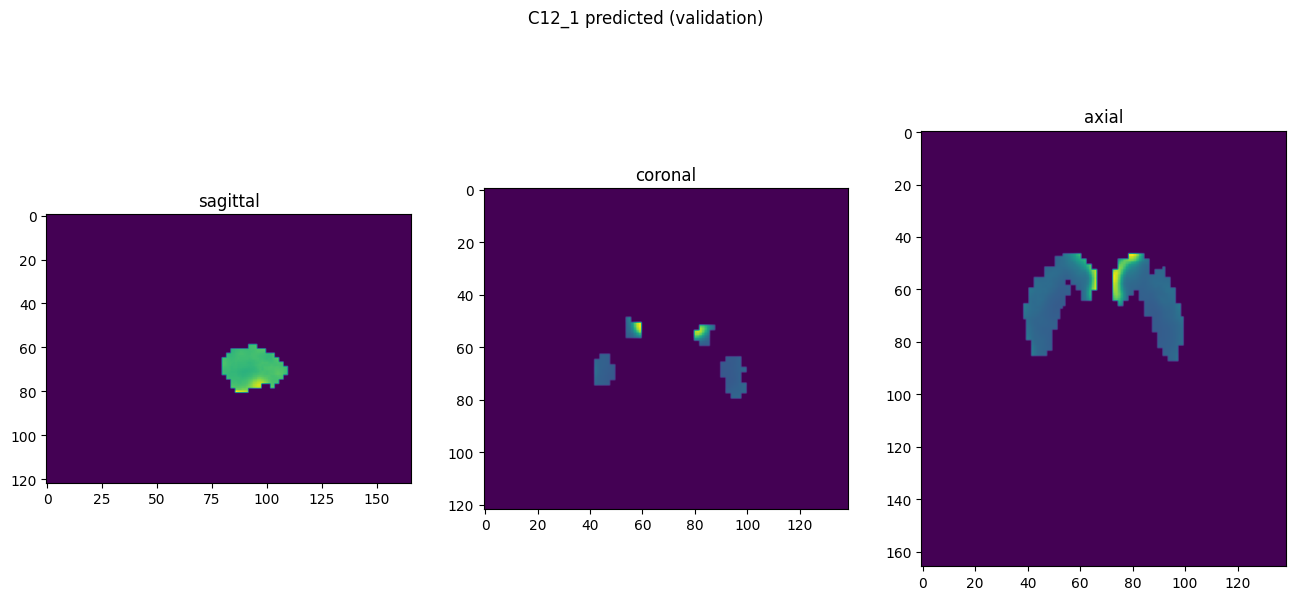

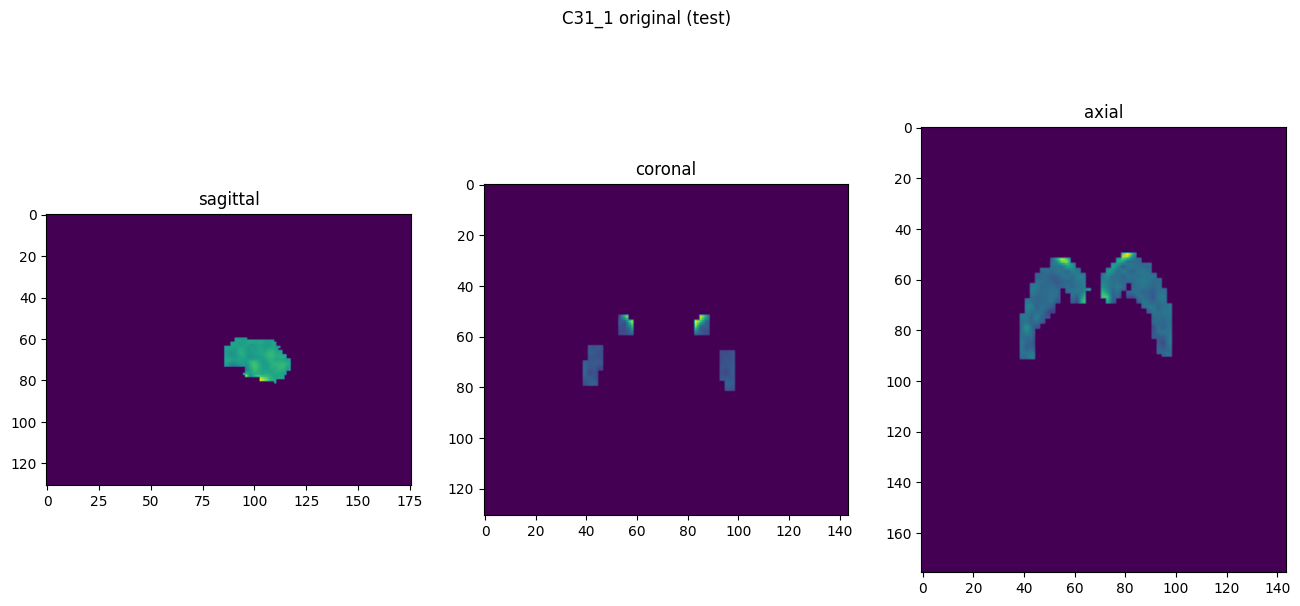

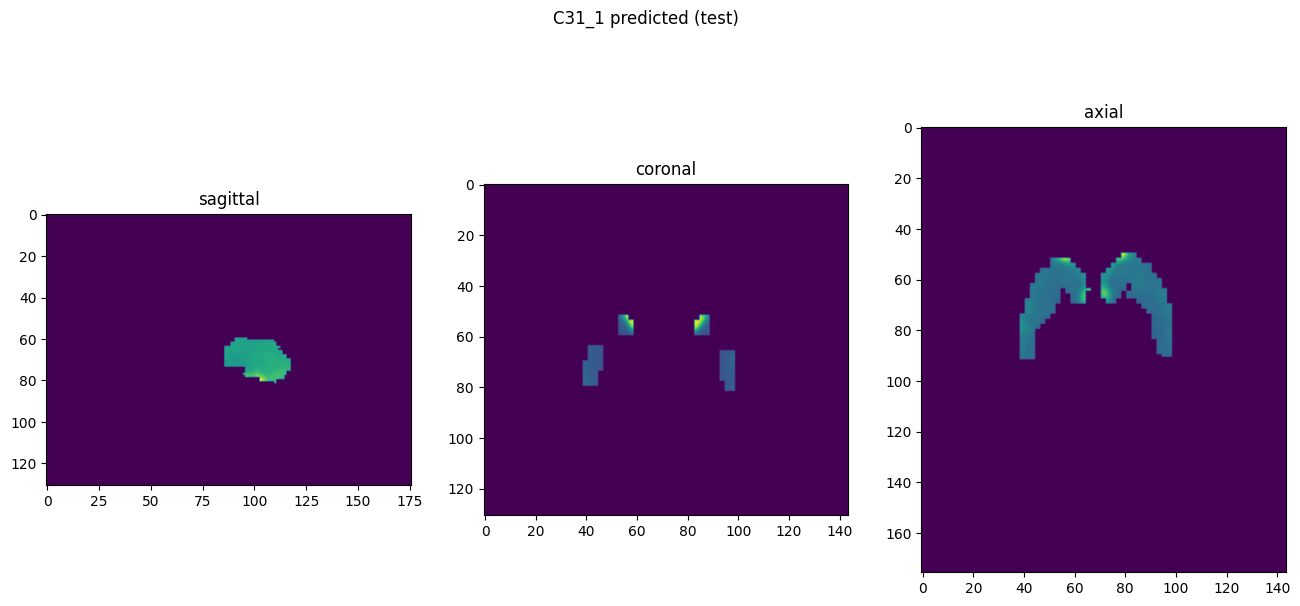

In [10]:
showResults(model, gen, threshold=None, background=False)